<a href="https://colab.research.google.com/github/helakhaddar/Moteur-de-Recherche-d-images-par-le-contenu-Approche-classique/blob/main/AutoencoderCBIR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder for Content  Based Image Retrieval
>Fait par : Bajar Imen / Khadhar Hela



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import load_model
import cv2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Build the autoencoder**

In [ ]:
def build_deep_autoencoder(img_shape, code_size):
    H, W, C = img_shape

    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(25 * 25 * 128))  # Adjust the size based on your desired output shape
    decoder.add(L.Reshape((25, 25, 128)))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=8, kernel_size=(3, 3), activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation=None, padding='same'))

    return encoder, decoder

In [ ]:
import numpy as np

npz_file_path = '/content/drive/MyDrive/database/American_coot/American_coot.npz'

# Chargez le fichier .npz
dataset = np.load(npz_file_path)

# Affichez les clés présentes dans l'archive
print("Keys in", npz_file_path, ":", dataset.files)

Keys in /content/drive/MyDrive/database/American_coot/American_coot.npz : ['arr_0']


# **Load Dataset**

In [ ]:
# Chemin vers le répertoire contenant votre base de données
database_path ="/content/drive/MyDrive/database"

# Liste pour stocker les caractéristiques (features) et les étiquettes (labels)
# Liste pour stocker les images et les étiquettes (noms de catégories)
images_list = []
labels_list = []
hashes = set()

# Parcourez chaque catégorie dans la base de données
for category in os.listdir(database_path):
    category_path = os.path.join(database_path, category)

    # Assurez-vous qu'il s'agit bien d'un dossier (et non d'un fichier)
    if os.path.isdir(category_path):
        # Parcourez chaque image dans la catégorie
        for image_file in os.listdir(category_path):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(category_path, image_file)

                # Lisez l'image en utilisant OpenCV (vous pouvez également utiliser PIL)
                image = cv2.imread(image_path)

                # Assurez-vous que l'image a été lue avec succès
                if image is not None:
                    h = hash(image.tobytes())

                    # Vérifiez si le hachage est déjà présent (doublon)
                    if h not in hashes:
                        # Ajoutez l'image, l'étiquette et le hachage aux listes
                        images_list.append(image)
                        labels_list.append(category)
                        hashes.add(h)

# Convertissez les listes en tableaux NumPy
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Vous pouvez maintenant utiliser images_array et labels_array comme votre ensemble de données
# Assurez-vous de diviser vos données en ensembles d'entraînement et de test si nécessaire
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_array, test_size=0.3, random_state=42)

In [ ]:
X_train = X_train.astype('float32') / 255
X_test= X_test.astype('float32') / 255

X_train.shape

(35, 200, 200, 3)

# **Show random images from train**

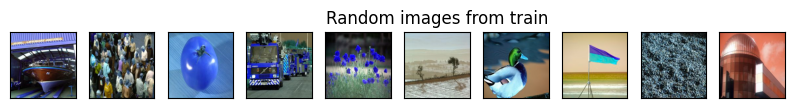

In [ ]:
# Reshape and visualize
n = 10
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(1, n, i + 1)

    plt.imshow(X_train[i], cmap='gray')  # Use cmap='gray' for grayscale visualization
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title('Random images from train')


# **Compile the model**

In [ ]:
img_shape = (200, 200, 3)

encoder, decoder = build_deep_autoencoder(img_shape, code_size=32)

In [ ]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
encoder.summary()
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 25, 25, 128)      

In [ ]:
autoencoder.fit(x=X_train, y=X_train, epochs=25, validation_data=[X_test, X_test])

Epoch 1/25
2/2 [==============================] - 11s 2s/step - loss: 0.2533 - accuracy: 0.3289 - val_loss: 0.2599 - val_accuracy: 0.2582
Epoch 2/25
2/2 [==============================] - 7s 2s/step - loss: 0.2349 - accuracy: 0.2835 - val_loss: 0.1602 - val_accuracy: 0.2364
Epoch 3/25
2/2 [==============================] - 9s 2s/step - loss: 0.1543 - accuracy: 0.2696 - val_loss: 0.1229 - val_accuracy: 0.2314
Epoch 4/25
2/2 [==============================] - 7s 2s/step - loss: 0.1129 - accuracy: 0.2664 - val_loss: 0.0841 - val_accuracy: 0.2404
Epoch 5/25
2/2 [==============================] - 9s 2s/step - loss: 0.0828 - accuracy: 0.2753 - val_loss: 0.0673 - val_accuracy: 0.3517
Epoch 6/25
2/2 [==============================] - 7s 2s/step - loss: 0.0653 - accuracy: 0.3395 - val_loss: 0.0806 - val_accuracy: 0.4303
Epoch 7/25
2/2 [==============================] - 8s 1s/step - loss: 0.0741 - accuracy: 0.4001 - val_loss: 0.0725 - val_accuracy: 0.4340
Epoch 8/25
2/2 [========================

# **Get descriptors for all images in the train**

In [ ]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

2/2 [==============================] - 1s 76ms/step


# **Image Search**


# Define Distance metric using the Nearest Neighbors Technique

In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

## Get similar images

## Show similar images

In [ ]:
def get_similar(image, n_neighbors=5):

  code = encoder.predict(image[None])
  (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)

  return distances,images[idx]

In [ ]:
def show_similar(image):

  distances, neighbors = get_similar(image,n_neighbors=4)
  images_to_display = neighbors

  # Create a grid of subplots
  num_images = len(images_to_display)
  rows = 1
  cols = num_images

  # Plot each image in a separate subplot
  for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images_to_display[i])
    plt.axis('off')  # Turn off axis labels

  plt.show()

1/1 [==============================] - 0s 76ms/step


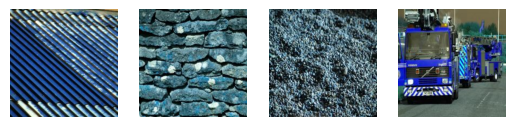

In [ ]:
show_similar(X_test[3])

1/1 [==============================] - 0s 44ms/step


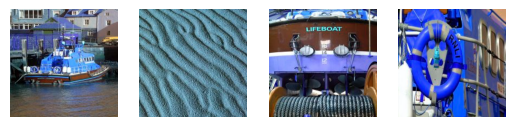

In [ ]:
show_similar(X_test[4])